In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import re
import random
import string
import matplotlib.pyplot as plt
from utilities import clean_arabic_tweet

In [3]:
pd.set_option('display.max_colwidth', -1)

# Data Preprocessing

## Loading Train Data

In [4]:
train_data_path = '../NADI2021_DEV.1.0/Subtask_1.2+2.2_DA/DA_train_labeled.tsv'

In [5]:
train_data = pd.read_csv(train_data_path, sep='\t')

## Delete province_labels 

In [6]:
del train_data['#4_province_label']

## Plot tweets ferquency for every country

<AxesSubplot:>

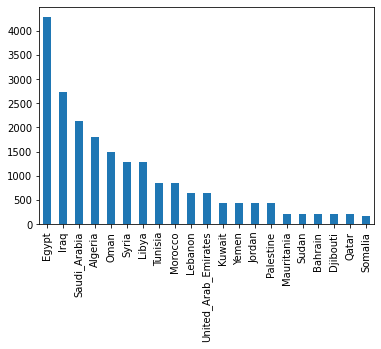

In [7]:
fig, ax = plt.subplots()
train_data['#3_country_label'].value_counts().plot(ax=ax, kind='bar')

In [8]:
train_data['#3_country_label'].value_counts()

Egypt                   4283
Iraq                    2729
Saudi_Arabia            2140
Algeria                 1809
Oman                    1501
Syria                   1287
Libya                   1286
Tunisia                 859 
Morocco                 858 
Lebanon                 644 
United_Arab_Emirates    642 
Kuwait                  429 
Yemen                   429 
Jordan                  429 
Palestine               428 
Mauritania              215 
Sudan                   215 
Bahrain                 215 
Djibouti                215 
Qatar                   215 
Somalia                 172 
Name: #3_country_label, dtype: int64

## preview samples 

In [9]:
# train_data.loc[train_data['#3_country_label'] == 'Somalia']

## clean tweets

In [10]:
tweets_cleaned = (train_data['#2_tweet'].apply(clean_arabic_tweet))

In [11]:
train_data['#2_tweet_clean']= tweets_cleaned

In [12]:
train_data.head(50)

,#1_tweetid,#2_tweet,#3_country_label,#2_tweet_clean
0,TRAIN_0,حاجة حلوة اكيد,Egypt,حاجه حلوه اكيد
1,TRAIN_1,عم بشتغلوا للشعب الاميركي اما نحن يكذبوا ويغشوا ويسرقوا ويقتلو شعوبهم ويعملوا لصالح اعدائهم,Iraq,عم بشتغلوا لشعب الاميركي اما نحن يكذبوا ويغشوا ويسرقوا ويقتلو شعوبهم ويعملوا لصالح اعداءهم
2,TRAIN_2,ابشر طال عمرك,Saudi_Arabia,ابشر طال عمرك
3,TRAIN_3,منطق 2017: أنا والغريب علي إبن عمي وأنا والغريب وإبن عمي علي أخويا. #قطع_العلاقات_مع_قطر #موريتانيا_مع_قطر,Mauritania,منطق انا والغريب علي ابن عمي وانا والغريب وابن عمي علي اخويا قطع العلاقات مع قطر موريتانيا مع قطر
4,TRAIN_4,شهرين وتروح والباقي غير صيف ملينا,Algeria,شهرين وتروح والباقي غير صيف ملينا
5,TRAIN_5,يابنتى والله ما حد متغاظ ولا مفروس منك ولا بيحسدك انتى عره اساسا.,Syria,يابنتي واله ما حد متغاظ ولا مفروس منك ولا بيحسدك انتي عره اساسا
6,TRAIN_6,نفس الوقت بأكد على صاحبتي ان اي هدف هتحطه وتخططله هيبوظ والأفضل التشاؤم واننا نتوقع الأسوء دايما والفشل عشان منعشمش نفسنا ع الفاضي,Egypt,نفس الوقت باكد علي صاحبتي ان اي هدف هتحطه وتخطله هيبوظ والافضل التشاءم وانا نتوقع الاسوء دايما والفشل عشان منعشمش نفسنا ع الفاضي
7,TRAIN_7,م تبطلي خرا بقا علشان مطلعهوش عليكي احترمي نفسك URL …,Egypt,م تبطلي خرا بقا علشان مطلعهوش عليكي احترمي نفسك
8,TRAIN_8,ما يله دخل !,Oman,ما يله دخل
9,TRAIN_9,هو حلو بس يتخربط ع طلاب المدراس ليك مايغيرونه عدنا,Iraq,هو حلو بس يتخربط ع طلاب المدراس ليك مايغيرونه عدنا


In [13]:
train_data.to_csv("./cleaned_data/cleaned_train_data_for_subtask1.csv", index=False, encoding="utf-8-sig")